In [1]:
import pandas as pd
import psycopg2
from psycopg2 import Error
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow import keras
from keras import models
from keras.models import sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping

In [10]:
df = pd.read_csv('E:/Program/PKLProjekt/Jupyter/Sales-Forecasting/material_df.csv')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39961 entries, 0 to 39960
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   material        39961 non-null  int64 
 1   posting_date    39961 non-null  object
 2   bill_qty_sku    39961 non-null  int64 
 3   material.1      39961 non-null  int64 
 4   posting_date.1  39961 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.5+ MB


,material,posting_date,bill_qty_sku,material.1,posting_date.1
0,11000000,2021-01-07,100,11000000,2021-01-07
1,11000000,2021-01-08,1900,11000000,2021-01-08
2,11000000,2021-01-09,2700,11000000,2021-01-09
3,11000000,2021-01-11,5700,11000000,2021-01-11
4,11000000,2021-01-12,23200,11000000,2021-01-12
5,11000000,2021-01-13,4700,11000000,2021-01-13
6,11000000,2021-01-14,7200,11000000,2021-01-14
7,11000000,2021-01-15,6800,11000000,2021-01-15
8,11000000,2021-01-16,1000,11000000,2021-01-16
9,11000000,2021-01-18,1100,11000000,2021-01-18


In [12]:
df = df.drop(['material.1','posting_date.1'],axis=1)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39961 entries, 0 to 39960
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   material      39961 non-null  int64 
 1   posting_date  39961 non-null  object
 2   bill_qty_sku  39961 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 936.7+ KB


,material,posting_date,bill_qty_sku
0,11000000,2021-01-07,100
1,11000000,2021-01-08,1900
2,11000000,2021-01-09,2700
3,11000000,2021-01-11,5700
4,11000000,2021-01-12,23200
...,...,...,...
39956,11002182,2021-05-28,1260
39957,11002182,2021-05-29,700
39958,11002182,2021-05-31,1400
39959,11002198,2021-04-30,250


In [4]:
monthly_data = df

In [5]:
monthly_data['posting_date'] = pd.to_datetime(monthly_data['posting_date'])
monthly_data.info()
monthly_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841600 entries, 0 to 841599
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   posting_date     841600 non-null  datetime64[ns]
 1   total_penjualan  841600 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 12.8+ MB


,posting_date,total_penjualan
0,2021-02-11,172975.00
1,2021-02-11,66600.00
2,2021-02-11,71456.00
3,2021-02-11,71019.00
4,2021-02-11,167795.00


In [6]:
monthly_data['total_penjualan'] = pd.to_numeric(monthly_data['total_penjualan'], errors='coerce')
monthly_data = monthly_data.groupby('posting_date').mean().reset_index()
monthly_data.info()
monthly_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   posting_date     118 non-null    datetime64[ns]
 1   total_penjualan  118 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.0 KB


,posting_date,total_penjualan
0,2021-01-07,2.513559e+05
1,2021-01-08,5.945508e+05
2,2021-01-09,5.555348e+05
3,2021-01-11,4.832709e+05
4,2021-01-12,1.182430e+06


Text(0, 0.5, 'sales')

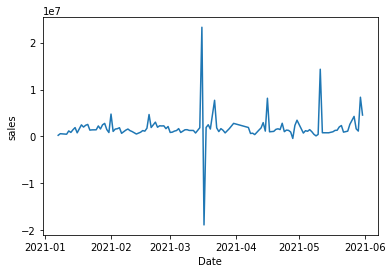

In [7]:
plt.plot(monthly_data['posting_date'], monthly_data['total_penjualan'])
plt.xlabel('Date')
plt.ylabel('sales')

In [15]:
supervised_data = monthly_data.drop(['posting_date'], axis = 1)

In [16]:
supervised_data.head()
supervised_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   total_penjualan  118 non-null    float64
dtypes: float64(1)
memory usage: 1.0 KB


In [17]:
for i in range(1,30):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['total_penjualan'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,total_penjualan,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,...,month_20,month_21,month_22,month_23,month_24,month_25,month_26,month_27,month_28,month_29
0,1.585592e+06,1.352804e+06,6.749466e+05,1.863090e+06,1.656699e+06,1.577183e+06,1.081620e+06,4.768919e+06,8.429147e+05,1.480980e+06,...,2.473927e+06,7.815582e+05,1.894416e+06,1.429257e+06,8.682038e+05,1.182430e+06,4.832709e+05,5.555348e+05,5.945508e+05,2.513559e+05
1,1.245011e+06,1.585592e+06,1.352804e+06,6.749466e+05,1.863090e+06,1.656699e+06,1.577183e+06,1.081620e+06,4.768919e+06,8.429147e+05,...,2.006929e+06,2.473927e+06,7.815582e+05,1.894416e+06,1.429257e+06,8.682038e+05,1.182430e+06,4.832709e+05,5.555348e+05,5.945508e+05
2,1.047885e+06,1.245011e+06,1.585592e+06,1.352804e+06,6.749466e+05,1.863090e+06,1.656699e+06,1.577183e+06,1.081620e+06,4.768919e+06,...,2.385314e+06,2.006929e+06,2.473927e+06,7.815582e+05,1.894416e+06,1.429257e+06,8.682038e+05,1.182430e+06,4.832709e+05,5.555348e+05
3,5.273029e+05,1.047885e+06,1.245011e+06,1.585592e+06,1.352804e+06,6.749466e+05,1.863090e+06,1.656699e+06,1.577183e+06,1.081620e+06,...,2.567238e+06,2.385314e+06,2.006929e+06,2.473927e+06,7.815582e+05,1.894416e+06,1.429257e+06,8.682038e+05,1.182430e+06,4.832709e+05
4,9.106434e+05,5.273029e+05,1.047885e+06,1.245011e+06,1.585592e+06,1.352804e+06,6.749466e+05,1.863090e+06,1.656699e+06,1.577183e+06,...,1.356262e+06,2.567238e+06,2.385314e+06,2.006929e+06,2.473927e+06,7.815582e+05,1.894416e+06,1.429257e+06,8.682038e+05,1.182430e+06
5,1.259240e+06,9.106434e+05,5.273029e+05,1.047885e+06,1.245011e+06,1.585592e+06,1.352804e+06,6.749466e+05,1.863090e+06,1.656699e+06,...,1.409551e+06,1.356262e+06,2.567238e+06,2.385314e+06,2.006929e+06,2.473927e+06,7.815582e+05,1.894416e+06,1.429257e+06,8.682038e+05
6,1.136129e+06,1.259240e+06,9.106434e+05,5.273029e+05,1.047885e+06,1.245011e+06,1.585592e+06,1.352804e+06,6.749466e+05,1.863090e+06,...,1.424118e+06,1.409551e+06,1.356262e+06,2.567238e+06,2.385314e+06,2.006929e+06,2.473927e+06,7.815582e+05,1.894416e+06,1.429257e+06
7,1.763693e+06,1.136129e+06,1.259240e+06,9.106434e+05,5.273029e+05,1.047885e+06,1.245011e+06,1.585592e+06,1.352804e+06,6.749466e+05,...,2.243813e+06,1.424118e+06,1.409551e+06,1.356262e+06,2.567238e+06,2.385314e+06,2.006929e+06,2.473927e+06,7.815582e+05,1.894416e+06
8,4.679418e+06,1.763693e+06,1.136129e+06,1.259240e+06,9.106434e+05,5.273029e+05,1.047885e+06,1.245011e+06,1.585592e+06,1.352804e+06,...,1.600047e+06,2.243813e+06,1.424118e+06,1.409551e+06,1.356262e+06,2.567238e+06,2.385314e+06,2.006929e+06,2.473927e+06,7.815582e+05
9,1.908404e+06,4.679418e+06,1.763693e+06,1.136129e+06,1.259240e+06,9.106434e+05,5.273029e+05,1.047885e+06,1.245011e+06,1.585592e+06,...,2.481478e+06,1.600047e+06,2.243813e+06,1.424118e+06,1.409551e+06,1.356262e+06,2.567238e+06,2.385314e+06,2.006929e+06,2.473927e+06


In [18]:
train_data = supervised_data[:-29]
test_data = supervised_data[-29:]
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()

In [19]:
X_test.shape

(29, 29)

In [20]:
sales_dates = monthly_data['posting_date'][-29:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
act_sales = monthly_data['total_penjualan'][-30:].to_list()

In [21]:
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [15]:
model = tf.keras.models.Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train_lstm.shape[1], X_test_lstm.shape[2])))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',
optimizer = keras.optimizers.Adam(1e-3))

In [22]:
model = tf.keras.models.load_model('/Users/muham/Machine-Learning/Sales-Forecasting/Model/LSTM_model_total-lagged.h5')

In [23]:
model.compile(loss='mean_squared_error',
optimizer = keras.optimizers.Adam(1e-3))
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 195:
        lr *= 0.5e-4
    elif epoch > 100:
        lr *= 1e-3
    elif epoch > 50:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    #print('Learning rate: ', lr)
    return lr
      # if epoch < 40:
    #   return 0.01
      # else:
      #   return 0.01 * np.math.exp(0.03 * (40 - epoch))
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay  

In [24]:
history = model.fit(X_train_lstm, y_train, 
                    epochs=50, 
                    batch_size=1, 
                    validation_data=(X_test_lstm, y_test), 
                    callbacks=[lrdecay])

Epoch 1/50
60/60 [==============================] - 4s 8ms/step - loss: 0.0467 - val_loss: 0.0189 - lr: 0.0010
Epoch 2/50
60/60 [==============================] - 0s 4ms/step - loss: 0.0396 - val_loss: 0.0175 - lr: 0.0010
Epoch 3/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0389 - val_loss: 0.0174 - lr: 0.0010
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0378 - val_loss: 0.0175 - lr: 0.0010
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0375 - val_loss: 0.0178 - lr: 0.0010
Epoch 6/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0367 - val_loss: 0.0177 - lr: 0.0010
Epoch 7/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0177 - lr: 0.0010
Epoch 8/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0177 - lr: 0.0010
Epoch 9/50
60/60 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0179 - lr: 0.0010
E

In [32]:
lstm_pred = model.predict(X_test_lstm, batch_size=1)
lstm_pred = lstm_pred.reshape(-1,1)
lstm_pred_test_set = np.concatenate([lstm_pred,X_test], axis=1)
lstm_pred_test_set = scaler.inverse_transform(lstm_pred_test_set)
lstm_pred_test_set.shape


(29, 30)

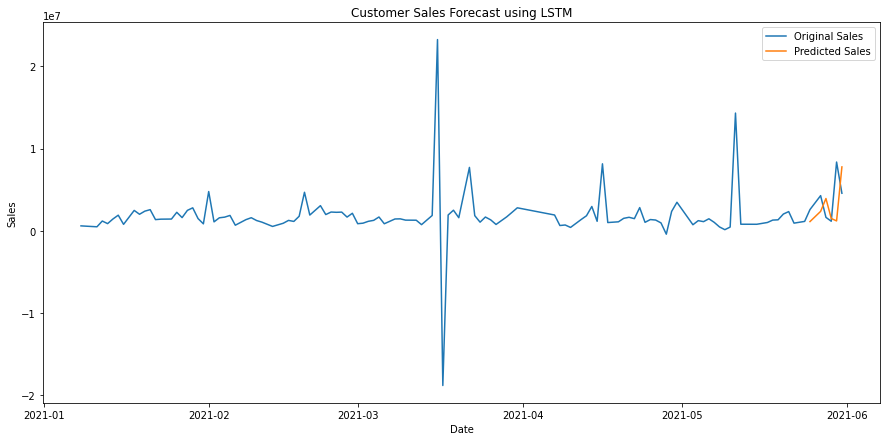

In [19]:
plt.figure(figsize=(15,7))
plt.plot(monthly_data['posting_date'], monthly_data['total_penjualan'])
plt.plot(predict_df['posting_date'], predict_df['lstm_pred'])
plt.title("Customer Sales Forecast using LSTM")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(["Original Sales", "Predicted Sales"])
plt.show()

In [22]:
tf.keras.models.save_model(model, '/Users/muham/Machine-Learning/Sales-Forecasting/Model/LSTM_model.h5')

In [95]:
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 1 to 117
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   posting_date     117 non-null    datetime64[ns]
 1   total_penjualan  117 non-null    float64       
 2   sales_diff       117 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.7 KB
